<a href="https://colab.research.google.com/github/yumengch/pyPDAF/blob/main/example/tutorial1_serial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Assimilation System with pyPDAF without parallelisation

---



pyPDAF is a Python interface to PDAF (Parallel Data Assimilation Framework). The framework is mainly designed for ensemble data assimilation systems with high-dimensional complex weather and climae models. It has applications to both research and operational purposes. The Python interface allows for the use of PDAF in Python, a flexible and rich environment.

As per its name, the framework is designed with the aim to implement efficient parallelised data assimilation system. In this practical, we provide a step-by-step tutorial on constructing a DA system with pyPDAF without using parallelisation. This tutorial is a simplification of the code used in `example/online` directory.

## Install pyPDAF
---
Before discussing the DA system, let us install pyPDAF first. If you are familiar with Python, you might have the package manager `conda` installed. This can be obtained using `anaconda` or `miniconda`. This functionality can be used on Google Colab as well.

### On local computer:

In your terminal or anaconda prompt, run `conda create -n pypdaf -c conda-forge yumengch::pypdaf==1.0.0 conda-forge::jupyter`.

You can then open this notebook using the command `jupyter notebook`


### On Google Colab (skip this section when you're not using Google Colab):

The following step will install `conda` on the Google Colab.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Now, we can install pyPDAF using conda

In [ ]:
%%capture
# installation of pyPDAF
!conda create -n pypdaf -c conda-forge yumengch::pypdaf==1.0.0

To provide a better view of PDAF output, we have to use wurlitzer

## Model and Observations

In a typical data assimilation application, one usually has a model that can simulate the system of interest. For example, in the numerical weather prediction, an atmosphere model is available. The same applies to ocean, sea ice, biogeochemistry and land surface models. These models usually provide a priori estimate (forecast) of the state of the system in sequential data assimilation schemes, or an initial guess/background state in variational methods. The motivation of data assimilation system is to obtain a good estimate of the state of the system with observations, which makes up another important component of data assimilation.

When constructing a data assimilation system in pyPDAF, providing the model state and observation as well as their connection and uncertainty information is the key task. Before we get into pyPDAF, let's look at the example model and observations in this tutorial. 

### Model

In this tutorial, a 2D model that propagates a sine wave along  in a rectangular domain is used for demonstration purpose. The model integration can be represented by a `step` function:

In [1]:
"""define the model integration step"""
import numpy as np

def step(field: np.ndarray) -> np.ndarray:
    """Roll array elements of i-th time step along a the first axis."""
    return np.roll(field, shift=1, axis=-2)

In the tutorial, the model has
- Spatial Domain: Two dimensional domain grid domain with $(nx \times ny) = (36 \times 18)$ grid points
- Total steps: we will run this model by `nsteps = 18` time steps

In [2]:
import numpy as np
# define the array for model field
nsteps = 18 # total time steps
nx = 36 # 36 columns
ny = 18 # 18 rows
# initial condition + 18 time steps, 18 rows and 36 columns
field = np.zeros((nsteps + 1, ny, nx))

For the sake of simplicity, a true initial condition is provided: 

In [3]:
""" this is a way to get all required data without using git and introducing additional libraries"""
import os
import urllib.request
# create input data directory
os.makedirs('inputs_online', exist_ok=True)
link_to_files = 'https://raw.githubusercontent.com/PDAF/PDAF/PDAF_V2.1/tutorial/inputs_online'
# get the initial truth
urllib.request.urlretrieve(f'{link_to_files}/true_initial.txt', os.path.join('inputs_online','true_initial.txt'))

('inputs_online/true_initial.txt', <http.client.HTTPMessage at 0x7f88784e72c0>)

We can read the initial condition to model field array:

In [4]:
"""read the initial condition of the model field"""
field[0] = np.loadtxt(os.path.join('inputs_online','true_initial.txt'))

Now, we can visualise the model evolution:

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure('animation')
ax = fig.add_subplot(111)
pc = ax.pcolormesh(field[0], cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(pc, ax=ax)

def draw_model(i):
  """Draw each model step
  """
  # run the model
  field[i+1] = step(field[i])
  pc.set_array(field[i+1])
  ax.set_title(f'Model step {i+1}')
  return pc,

# make an animation
anim = animation.FuncAnimation(fig, draw_model, frames=nsteps, interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

### Observations

Observations are given for each time steps stored in 'obs_step*.txt'

In [6]:
"""retrieve observations"""
for i in range(nsteps):
    urllib.request.urlretrieve(f'{link_to_files}/obs_step{i+1}.txt', os.path.join('inputs_online',f'obs_step{i+1}.txt'))

- Among 648 grid points only 28 grid points have observations. This is because most DA methods can estimate grid points without observations by assuming each grid points form a multi-variate Gaussian distribution.
- Compared to the truth, these observations have an error of 0.5
- The retrieved data use `-999` as missing values

In [7]:
# define observation array
obs = np.ma.zeros((nsteps, ny, nx))
fig = plt.figure('animationObs')
ax = fig.add_subplot(111)
pc = ax.pcolormesh(obs[0], cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(pc, ax=ax)
def draw_model(i):
  """Draw obs. at each model step
  """
  obs[i] = np.loadtxt(os.path.join('inputs_online', f'obs_step{i+1}.txt'))
  obs[i] = np.ma.masked_where(np.isclose(obs[i], -999.), obs[i])
  pc.set_array(obs[i])
  ax.set_title(f'Observation at step {i+1}')
  return pc,

# make an animation
anim = animation.FuncAnimation(fig, draw_model, frames=18, interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

In this tutorial, we can actually obtain the truth,  

In [8]:
for i in range(18):
    # get all truth
    urllib.request.urlretrieve(f'{link_to_files}/true_step{i+1}.txt', os.path.join('inputs_online', f'true_step{i+1}.txt'))

In comparison to the truth, we can check the observation error and calculate it as a sanity check.

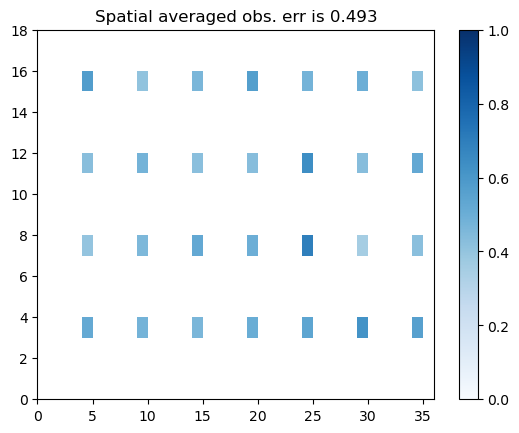

In [9]:
# calculate the root mean squared obs. err in time
err = np.sqrt(np.sum((field[1:] - obs)**2, axis=0)/nsteps)
# plot the observation error
fig = plt.figure('R')
ax = fig.add_subplot(111)
pc = ax.pcolormesh(err, cmap='Blues', vmin=0., vmax=1.)
ax.set_title(f'Spatial averaged obs. err is {np.round(np.mean(err), 3)}')
fig.colorbar(pc, ax=ax)

## Set up a data assimilation system using pyPDAF

Now, we can construct our data assimilation systems. As in many other Python programs, we use third-party packages for the system. This is one of the benefits of a Python system as many functionalities are available. In this tutorial, `pyPDAF`, `numpy` and `mpi4py` is used. Note that even though parallel features are not used in this tutorial, `mpi4py` is still required.

In [10]:
%%capture
"""For the sake of compatibility of running it in Google Colab, we install wurlitzer here. 
   This is not essential if you run it on your local computer, but you will need to remove
   all code related to wurlitzer in this notebook."""
# wurlitzer is a package that allows us to see PDAF output
!pip install wurlitzer

In [11]:
import pyPDAF.PDAF as PDAF
import mpi4py.MPI as MPI
import numpy as np
from wurlitzer import pipes

### Initialise PDAF

The initialisation of PDAF tells PDAF the our choice of data assimilation algorithms, ensemble size, inflation factor, and the dimension of the state vector. Currently (up to PDAF V2.3.1), any DA methods in PDAF require these options. However, some methods can only be executed with additional parameters.

In this tutorial, the **error space transform Kalman filter (ESTKF)** is used with **9** ensemble members. We will estimate the state of every model grid point, which gives us a state vector with the size of nx × ny = 36 × 18 = 648. The `filtertype` and `subtype` here specifies the DA method and will be given as an argument in `pyPDAF.PDAF.init` function. A full list of supported methods can be found in [PDAF wiki](https://pdaf.awi.de/trac/wiki/AvailableOptionsforInitPDAF).

In [12]:
# using error space transform Kalman filter (ESTKF)
filtertype = 6
# standard form
subtype = 0
# dimension of the state vector
# if model is parallelised, this is the dimension of state vector on each process
dim_state_p = nx*ny
# number of ensemble members
dim_ens = 9
# forget factor
forget_factor = 1.0

In addition to the above information, PDAF also asks for an **initial ensemble**. This information is given by the user-supplied function. These functions have fixed interface. Therefore
- the input arguments and return variables should not be changed.

In this user-supplied function, the primary purpose is to fill the `ens_p` array given as an input argument and return the ensemble to PDAF. Except for `ens_p`, other input arguments and returned variables assist the users specifying an initial ensemble. In this tutorial, the initial ensemble is read from given text files. 

In real applications, we may need to use algorithms to generate perturbations to create an initial ensemble. For the sake of conciseness, documentation of the input arguments and return variable of this function can be found in [pyPDAF documentation](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.init.html#pyPDAF.PDAF.init)

In [13]:
def init_ens_pdaf(filtertype, dim_p, dim_ens, state_p, uinv, ens_p, status_pdaf):
    """Here, only ens_p variable matters while dim_p and dim_ens defines the
    size of the variables. uinv, state_p are not used in this example.

    status_pdaf is used to handle errors which we will not do it in this example.
    """
    # get initial ensemble
    for i in range(dim_ens):
        urllib.request.urlretrieve(f'{link_to_files}/ens_{i+1}.txt', os.path.join('inputs_online', f'ens_{i+1}.txt'))    
        ens_p[:, i] = np.loadtxt(os.path.join('inputs_online', f'ens_{i+1}.txt')).ravel()
    return state_p, uinv, ens_p, status_pdaf

With these information, we can call PDAF function [`PDAF.init`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.init) to initialise the DA system

In [14]:
# this gives the verbose level of the PDAF, here we use 3 which is very verbose
screen = 3
# current step of the model which is 0
current_step = 0
# initialise the MPI package
if not MPI.Is_initialized():
    MPI.Init()
with pipes() as (out, err):
    _, _, status = PDAF.init(filtertype, subtype, current_step,
                            np.array([dim_state_p, dim_ens], dtype=np.intc),
                            np.array([forget_factor, ]),
                            MPI.COMM_WORLD.py2f(), MPI.COMM_WORLD.py2f(),
                            MPI.COMM_WORLD.py2f(),
                            task_id=1, n_modeltasks=1, in_filterpe=True,
                            py__init_ens_pdaf=init_ens_pdaf,
                            in_screen=screen)
# print PDAF screen output
print (out.read())


PDAF    ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PDAF    +++                        PDAF                        +++
PDAF    +++        Parallel Data Assimilation Framework        +++
PDAF    +++                                                    +++
PDAF    +++                   Version 2.3                      +++
PDAF    +++                                                    +++
PDAF    +++                   Please cite                      +++
PDAF    +++ L. Nerger and W. Hiller, Computers and Geosciences +++
PDAF    +++ 2013, 55, 110-118, doi:10.1016/j.cageo.2012.03.026 +++
PDAF    +++   when publishing work resulting from using PDAF   +++
PDAF    +++                                                    +++
PDAF    +++          PDAF itself can also be cited as          +++
PDAF    +++  L. Nerger. Parallel Data Assimilation Framework   +++
PDAF    +++  (PDAF). Zenodo. 2024. doi:10.5281/zenodo.7861812  +++
PDAF    +++++++++++++++++++++++++++++++++++++++++++++++++++++

### Distribution of the ensemble from PDAF
After PDAF initialisation, PDAF should distribute the ensemble back to the model to initialise the following forecast. This is accomplished by [`pyPDAF.PDAF.get_state`](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.get_state.html#pyPDAF.PDAF.get_state) function. 

This function depends on three user-supplied functions that are executed in the following sequence:
1. Processing the initial PDAF ensemble by user-supplied function `py__prepoststep_state_pdaf`. This is because the ensemble stored in PDAF may not satisify some physical constraints such as balance conditions (hydrostatic balance/constitutive relations) or boundness (percentage values/chemical concentrations).
2. PDAF should distribute the initial ensemble to the model for following model forecasts in `py__distribute_state_pdaf`. This function relates the model field to the state vector used by PDAF.
3. PDAF perform actual data assimilation based on its internal counter for the time steps. In `pyPDAF.PDAF.init` function, we specify the initial time step. Now, a user-supplied function informs PDAF the data assimilation is performed after `nsteps` of forecast in `py__next_observation_pdaf`. The internal time step counter is incremented by one whenever one calls the assimilation functions for [fully parallel DA algorithms](https://yumengch.github.io/pyPDAF/API.html#fully-parallel-da-algorithms), or [flexible DA algorithms](https://yumengch.github.io/pyPDAF/API.html#flexible-da-algorithms). This means, data assimilation will performed when one of the assimilation functions is called at the `nsteps`-th step.

To implement these user-supplied functions, we define a `PdafDistributor` class.

In [15]:
class PdafDistributor:
    """Distribute the ensemble members to the model tasks
    """
    def __init__(self, nx, ny, dim_ens):
        # counter for the i-th ensemble member when distribute
        self.i_ens_pdaf = 0
        # define the model field based on the ensemble
        self.nx, self.ny = nx, ny
        self.field = np.zeros((dim_ens, ny, nx))

In this non-parallel code, PDAF will distribute ensemble members one by one from the input argument `state_p` with `distribute_state` method. We can keep track of the current ensemble member by a counter `self.i_ens_pdaf`.

In [16]:
class PdafDistributor(PdafDistributor):
    def distribute_state(self, dim_p, state_p):
        """PDAF will distribute state vector (state_p) to model field
        """
        self.field[self.i_ens_pdaf] = state_p[:].reshape((self.ny, self.nx))
        self.i_ens_pdaf += 1
        return state_p

    def reset_ens_index(self):
        """reset ensemble index to 0
        """
        self.i_ens_pdaf = 0

In this simple model example, there are no need for actual processing of the ensemble. Therefore, we only show screen output of root mean squared error based on sampled variance.

In [17]:
class PdafDistributor(PdafDistributor):
    def initial_process(self, step, dim_p, dim_ens, dim_ens_l, dim_obs_p, state_p, uinv, ens_p, flag):
        """initial processing of the ensemble before it is distributed to model fields
        """
        print (f'RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        return state_p, uinv, ens_p

When obtaining the initial ensemble, users also need to provide information about when do we do the next analysis based on the arrival of the new observations. In our case, we have observations for each time step, but we'd like to assimilate it every other time steps.

In [18]:
class PdafDistributor(PdafDistributor):
    def next_observation(self, stepnow, nsteps, doexit, time):
        # next observation will arrive at `nsteps' step
        nsteps = 2
        # doexit = 0 means that PDAF will continue to distribute state
        # to model for further integrations
        doexit = 0
        # model time is not used here as we only use steps to define the time
        return nsteps, doexit, time

Here, we call pyPDAF's [`get_state`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.get_state) function where it will also execute our user-supplied functions.

In [19]:
status = 0
distributor = PdafDistributor(nx, ny, dim_ens)
# making sure that distributor.i_ens_pdaf = 0
# before state vector distribution
distributor.reset_ens_index()
steps_for = 0
doexit = 0
# loop over all dimensions
for i in range(dim_ens):
    with pipes() as (out, err):
        steps_for, time, doexit, status = PDAF.get_state(steps_for, doexit,
                                          distributor.next_observation,
                                          distributor.distribute_state,
                                          distributor.initial_process,
                                          status)
    print (out.read())
# put model variable in distributor back to model
field = distributor.field

RMS error according to sampled variance: 0.5434035532444028


PDAF ----------------------------------------------------------------
PDAF                    +++++ ASSIMILATION +++++
PDAF ----------------------------------------------------------------
PDAF     Call pre-post routine at initial time
PDAF     --- duration of prestep:     0.000 s
PDAF Forecast -------------------------------------------------------
PDAF     Evolve state ensemble











The `get_state` function returns `steps_for`, `time` and `doexit` variable, which are given in `next_observation` function.

### Forward data assimilation system

Data assimilation combines the model forecast and the observations. Hence, to perform data assimilation, at each analysis step, PDAF must collect the new forecast from the model and read observations. The assimilation also needs a function that connects the forecast state to observations which usually is denoted as observation operator. To ensure the flexibility of the framework, these information depends on the user-supplied functions. This is because each observation type and model are different so one should expect the users can handle these information.

In the serial system, the cycling can be divided into following steps:
1. model forecast using `step` function
2. put model forecast into PDAF state vector/ensemble array to perform DA using [`pyPDAF.PDAF.omi_put_state_global`](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.omi_put_state_global.html#pyPDAF.PDAF.omi_put_state_global).
3. get the analysis state vector to initialise the next model forecast using [`pyPDAF.PDAF.get_state`](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.get_state.html#pyPDAF.PDAF.get_state).

In above steps, the model forecast function is implemented in [`step`](#Model) function. Here, we demonstrate the user-supplied functions used by `pyPDAF.PDAF.omi_put_state_global`.

#### User-supplied functions
In the assimilation step, the two primary purposes is defined by `PdafCollector` and `Obs` classes. The `PdafCollector` class obtains the model forecast and the `Obs` will handle observations using the `Observation Module Infrastructure` in PDAF, a scheme to ease the difficulty in handling observations.

In [20]:
class PdafCollector:
    def __init__(self, nx, ny, field):
        # counter for the i-th ensemble member when distribute
        self.i_ens_pdaf = 0
        self.nx = nx
        self.ny = ny
        # define the model field based on the ensemble
        self.field = field

class Obs:
    def __init__(self, i_obs):
        # i_obs-th observations in the system starting from 1
        self.i_obs = i_obs

##### Collecting forecast
Before going into the details of observation handling, we first
1. get functions that collects the model forecast [(`collect_state_pdaf`)](https://yumengch.github.io/pyPDAF/UserFunc.html#pyPDAF.UserFunc.py__collect_state). Similar to `distribute_state_pdaf`, the state vector is collected for each ensemble member from model field.
2. preprocess the ensemble forecast before the data assimilation. In the pre-processing step, we calculate the forecast error and save the forecast ensemble. This is the last step before assimilation so it could help us understand the raw forecast data. In the pre-process, the `step` argument is negative
3. post-process the analysis ensemble after the assimilation.

In [21]:
class PdafCollector(PdafCollector):
    def collect_state(self, dim_p, state_p):
        """PDAF will collect state vector (state_p) from model field
        """
        state_p[:] = self.field[self.i_ens_pdaf].ravel()
        self.i_ens_pdaf += 1
        return state_p

    def reset_ens_index(self):
        """reset ensemble index to 0
        """
        self.i_ens_pdaf = 0

    def preprocess(self, step, dim_ens, ens_p):
        """preprocessing of the ensemble before it is used by DA algorithms
        """
        print (f'Forecast RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        for i in range(dim_ens):
            np.savetxt(os.path.join('outputs', f'ens_{i+1}_step{-step}_for.txt') , ens_p[:, i].reshape((self.ny, self.nx)) )

    def postprocess(self, step, dim_ens, ens_p):
        """post-processing of the ensemble before it is distributed to model fields
        """
        print (f'Analysis RMS error according to sampled variance: {np.sqrt(np.mean(np.var(ens_p, axis=1)))}')
        for i in range(dim_ens):
            np.savetxt(os.path.join('outputs', f'ens_{i+1}_step{step}_ana.txt' ), ens_p[:, i].reshape((self.ny, self.nx)) )

    def prepostprocess(self, step, dim_p, dim_ens, dim_ens_p, dim_obs_p, state_p, uinv, ens_p, flag):
        if step < 0:
          self.preprocess(step, dim_ens, ens_p)
        else:
          self.postprocess(step, dim_ens, ens_p)
        return state_p, uinv, ens_p


##### Handling observations
Another essential ingredient of data assimilation is observation. Here, user-supplied functions give all information about the observations to PDAF. We use the OMI scheme in PDAF to handle observations. Without any localisations, only two user-supplied functions are required with the OMI scheme.

Before we use the OMI scheme, we need to provide the number of observation types by [`PDAF.omi_init`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_init). This function 

Here, we use only one type of observations.

In [22]:
PDAF.omi_init(1)

In this very simple example, the OMI observation functions may look a bit verbose, but it can be useful for more complex systems.

The OMI has four mandatory properties:
- [`doassim`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_doassim): whether this observation is assimilated. If `doassim = 1`, this observation will be assimilated. If `doassim = 0`, it will not be assimilated.
- [`disttype`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_disttype): In localisation, how do we calculate the distance between grid points? e.g., Cartesian, geographic, or great circle distance on a sphere. We do not use localisation in this example, but we still have to provide this option.
- [`ncoord`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_ncoord): Number of coordinates used for computation in localisation. In our example, as we have a 2D domain, the number should be 2.
- [`id_obs_p`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_set_id_obs_p): Indices of observed field in state vector. This is a 2D array that should have the same length as the observector vector for each dimension. If the observations do not need interpolation (e.g., observations are co-located with model grid points), the first dimension is 1. In this case, if the i-th observation is at the j-th element of the state vector, the i-th element of `id_obs_p` is `j`. If interpolation is needed, each dimension is the adjacent model grid points.

In Fortran, these properties can be given to derived type `obs_f`. In the pyPDAF, setter functions are provided. In the [`PDAF.omi_gather_obs`](https://yumengch.github.io/pyPDAF/PDAF.html#pyPDAF.PDAF.omi_gather_obs) function, PDAFomi collects 
- the observation vector
- error variance
- the spatial coordinate of the observations

This function also returns the dimension of the observation for given observation type.

In [23]:
class Obs(Obs):
    def init_dim(self, step, dim_obs):
        # We always assimilate the observation
        PDAF.omi_set_doassim(self.i_obs, 1)
        # Type of distance computation to use for localization
        # It is mandatory for OMI even if we don't use localisation
        PDAF.omi_set_disttype(self.i_obs, 0)
        # Number of coordinates use for distance computation
        PDAF.omi_set_ncoord(self.i_obs, 2)

        # read observations
        obs = np.loadtxt(os.path.join('inputs_online', f'obs_step{step}.txt'))
        # get the dimension of the model grid
        ny, nx = obs.shape
        # flatten the observations
        obs = obs.ravel()
        # a mask for observed gridpoints
        condition = np.logical_not(np.isclose(obs, -999))

        # observation vector
        y = obs[condition]

        # The relationship between observation and state vector
        # we only have 28 osbervations and each observation corresponds to
        # the grid point of one element in the state vector
        # id_obs_p gives the indices of observed field in state vector
        # the id starts from 1
        id_obs_p = np.zeros((1, len(y)), dtype=np.intc)
        id_obs_p[0] = np.arange(1, len(obs) + 1, dtype=np.intc)[condition]
        PDAF.omi_set_id_obs_p(self.i_obs, id_obs_p)

        # inverse of observation variance
        ivar_obs_p = 1./0.5/0.5*np.ones_like(y)

        # coordinate of each observations
        ocoord_p = np.zeros((2, len(y)))
        ocoord_p[0] = np.tile(np.arange(nx), ny)[condition]
        ocoord_p[1] = np.repeat(np.arange(ny), nx)[condition]

        # not being used here, only used for localisation
        local_range = 0.
        dim_obs = PDAF.omi_gather_obs(self.i_obs, y,
                                     ivar_obs_p, ocoord_p, local_range)
        return dim_obs

The other user-supplied function in this example will be the observation operator. In this simple example, the state vector in the observation space can be conviently obtained by the OMI function [`pyPDAF.PDAF.omi_obs_op_gridpoint`](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.omi_obs_op_gridpoint.html#pyPDAF.PDAF.omi_obs_op_gridpoint) using the information provided in the `init_dim_obs` function. This function provides an observation operator where observations are located on the model grid points. When observations are not located on model grid points, PDAFomi also provides functions using linear interpolations on various grid. In this case, one may need to refer to [PDAF documentation](https://pdaf.awi.de/trac/wiki/OMI_observation_operators#Initializinginterpolationcoefficients) and [`id_obs_p` doc](https://yumengch.github.io/pyPDAF/_autosummary/pyPDAF.PDAF.omi_set_id_obs_p.html#pyPDAF.PDAF.omi_set_id_obs_p) for a better explanation.

In [24]:
class Obs(Obs):
    def op(self, step, dim_p, dim_obs_p, state_p, ostate):
        """observation operator
        """
        return PDAF.omi_obs_op_gridpoint(self.i_obs, state_p, ostate)

##### Forward loop

Now, we can write code for the forward DA system:

In [25]:
os.makedirs('outputs', exist_ok=True)

In [26]:
# create directory to
current_step = 0
# full DA system integration loop
while current_step < nsteps:

    # model integration
    for _ in range(steps_for):
        field = step(field)
        current_step += 1

    # PDAF does assimilation
    collector = PdafCollector(nx, ny, field)
    obs = Obs(1)
    collector.reset_ens_index()
    for i in range(dim_ens):
        with pipes() as (out, err):
            status = PDAF.omi_put_state_global(collector.collect_state,
                                      obs.init_dim, obs.op,
                                      collector.prepostprocess)
        print (out.read())

    # PDAF distribute analysis back to model
    distributor = PdafDistributor(nx, ny, dim_ens)
    distributor.reset_ens_index()
    for i in range(dim_ens):
        with pipes() as (out, err):
            # here, the distributor does not call initial_process function at all
            # as it is only called when it is called by the first time.
            steps_for, time, doexit, status = PDAF.get_state(steps_for, doexit,
                                              distributor.next_observation,
                                              distributor.distribute_state,
                                              distributor.initial_process,
                                              status)
        print (out.read())
    field = distributor.field









Forecast RMS error according to sampled variance: 0.5434035532444028
Analysis RMS error according to sampled variance: 0.12016145640351511
PDAF     --- duration of forecast phase:     0.064 s
PDAF     Call pre-post routine after forecast; step       2
PDAF     --- duration of prestep:     0.007 s
PDAF Analysis -------------------------------------------------------
PDAF       2   Assimilating observations - ESTKF
PDAFomi     --- Initialize observation type ID   1
PDAFomi     --- Use process-local observations for global filters
PDAFomi        --- Number of full observations      28
PDAF     --- PE-domain      0 dimension of observation vector        28
PDAF     Perform ensemble transformation
PDAF     --- use symmetric square-root of A
PDAF     --- Compute deterministic Omega
PDAF     --- Ensemble update: use blocking with size   200
PDAF     --- update duration:     0.002 s
PDAF     Call pre-post routine after analysis step
PDAF     --- duration of poststep:     0.009 s
PDAF F

### Does analysis look better than forecast?

In [27]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from IPython.display import HTML
dim_ens=9
ny, nx = 18, 36
# define diagnotics and model fields
spread = {'fcst': np.zeros(9), 'ana': np.zeros(9)}
RMSE = {'fcst': np.zeros(9), 'ana': np.zeros(9)}
field = {'truth': np.zeros((ny, nx)),
         'fcst': np.zeros((dim_ens, ny, nx)),
         'ana': np.zeros((dim_ens, ny, nx))
         }
for key in spread:
    spread[key][:] = np.nan
    RMSE[key][:] = np.nan
# time
time = np.arange(2, 20, 2)

# get figure
fig = plt.figure('err')
w, h = fig.get_size_inches()
fig.set_size_inches(2*w, 2*h)
# define the time series plot
ax = fig.add_subplot(212)
ax.set_title('Time series of the ensemble spread and RMSE')
ax.set_ylim([0., 1.2])
ax.set_xlim([time[0] - 1, time[-1] + 1])
lines = []
for key, c in zip(spread, ['k', 'r']):
    line, = ax.plot(time, spread[key], color=c, linestyle='dashed',label=f'{key} spread')
    lines.append(line)
    line, = ax.plot(time, RMSE[key], color=c, linestyle='solid',label=f'{key} RMSE')
    lines.append(line)
ax.legend()
# define pcolormesh plots
ax = {'fcst': fig.add_subplot(221), 'ana': fig.add_subplot(222),}
pc = dict()
for key in ax:
    pc[key] = ax[key].pcolormesh(field[key].mean(0) - field['truth'],
                                 cmap='coolwarm', vmin=-.06, vmax=.06)
    fig.colorbar(pc[key], ax=ax[key])

def draw_error(i):
    """Draw error at each analysis time step
    """
    field['truth'] = np.loadtxt(os.path.join('inputs_online', f'true_step{i}.txt'))
    for j in range(1, dim_ens + 1):
        field['fcst'][j-1] = np.loadtxt(os.path.join('outputs', f'ens_{j}_step{i}_for.txt'))
        field['ana'][j-1]  = np.loadtxt(os.path.join('outputs', f'ens_{j}_step{i}_ana.txt'))

    for j, key in enumerate(spread):
        spread[key][i//2 - 1] = field[key].std(0).mean()
        RMSE[key][i//2 - 1] = np.sqrt(np.mean((field[key].mean(0) - field['truth'])**2))
        lines[2*j].set_ydata(spread[key])
        lines[2*j + 1].set_ydata(RMSE[key])

    for key in ax:
        ax[key].set_title(f'{key} error ({np.round(RMSE[key][i//2 - 1], 3)})')
        pc[key].set_array(field[key].mean(0) - field['truth'])

    return pc['fcst'], pc['ana'], *lines

# make an animation
anim = animation.FuncAnimation(fig, draw_error, frames=time, interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())